In [3]:
import numpy as np
import os
import math
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import TimeLimit
from gymnasium.utils import seeding

In [4]:
# ============================
# Cell 1 — Imports + Custom Env (Continuous CartPole Swing-Up) + EDGE RESPAWN
# ============================================================
# PyTorch GPU setup (replaces TF setup)
# ============================================================
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Torch version:", torch.__version__)
print("✅ CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("✅ GPU:", torch.cuda.get_device_name(0))
    # Optional perf tweak for float32 matmul on newer GPUs
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

# ============================================================
# Dtypes
# ============================================================
# Keep env features float32 (fast). For GP training you can switch to float64 later.
DTYPE_NP = np.float32
# Dtypes for GPU-friendly pipeline
# ============================================================
# Env can stay float32; GP features should also be float32 to avoid slow casts.
DTYPE_NP = np.float32

# ============================================================
# Angle helpers
# ============================================================
def wrap_pi(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def obs_to_state(obs):
    """
    obs = [x, x_dot, theta, theta_dot]
    Wrap theta to (-pi, pi] for stability.
    """
    x, xdot, th, thdot = float(obs[0]), float(obs[1]), float(obs[2]), float(obs[3])
    th = wrap_pi(th)
    return x, xdot, th, thdot

U_MIN, U_MAX = -1.0, 1.0

def state_to_features(x, xdot, theta, thetadot, u,
                      x_scale=2.4, v_scale=3.0, w_scale=8.0,
                      dtype=DTYPE_NP):
    """
    GP features (D=6), bounded:
        [ tanh(x/x_scale),
          tanh(xdot/v_scale),
          sin(theta),
          cos(theta),
          tanh(thetadot/w_scale),
          u ]
    Returns float32 by default (GPU-friendly).
    """
    x_feat = np.tanh(x / x_scale)
    xdot_feat = np.tanh(xdot / v_scale)
    w_feat = np.tanh(thetadot / w_scale)
    return np.array(
        [x_feat, xdot_feat, np.sin(theta), np.cos(theta), w_feat, float(u)],
        dtype=dtype
    )

# ============================================================
# Custom Continuous CartPole Swing-Up Env (CPU physics; that's OK)
# ============================================================
class ContinuousCartPoleSwingUpEnv(gym.Env):
    metadata = {"render_modes": ["rgb_array", "human"], "render_fps": 50}

    def __init__(self, render_mode=None, start_down=True):
        super().__init__()

        # physics
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5
        self.polemass_length = self.masspole * self.length

        # control
        self.force_mag = 30.0
        self.tau = 0.02
        self.min_action = -1.0
        self.max_action = 1.0

        # track limits
        self.x_threshold = 2.4

        # reset mode
        self.start_down = bool(start_down)

        # render
        self.render_mode = render_mode
        self.state = None
        self.np_random = None
        self.seed()

        # spaces
        high = np.array(
            [
                self.x_threshold * 2,
                np.finfo(np.float32).max,
                np.finfo(np.float32).max,
                np.finfo(np.float32).max,
            ],
            dtype=np.float32,
        )

        self.action_space = spaces.Box(
            low=np.array([self.min_action], dtype=np.float32),
            high=np.array([self.max_action], dtype=np.float32),
            shape=(1,),
            dtype=np.float32,
        )
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def stepPhysics(self, force):
        x, x_dot, theta, theta_dot = self.state
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        temp = (force + self.polemass_length * theta_dot * theta_dot * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta * costheta / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc
        return (x, x_dot, theta, theta_dot)

    def step(self, action):
        action = np.asarray(action, dtype=np.float32).reshape(1,)
        assert self.action_space.contains(action), f"{action} invalid"

        u = float(action[0])
        force = self.force_mag * u

        self.state = self.stepPhysics(force)
        x, x_dot, theta, theta_dot = self.state

        terminated = bool(x < -self.x_threshold or x > self.x_threshold)
        truncated = False  # TimeLimit handles truncation

        reward = (
            +1.0 * math.cos(theta)
            -0.01 * (x * x)
            -0.001 * (x_dot * x_dot)
            -0.001 * (theta_dot * theta_dot)
            -0.001 * (u * u)
        )

        obs = np.array([x, x_dot, theta, theta_dot], dtype=np.float32)
        info = dict(x=x, x_dot=x_dot, theta=theta, theta_dot=theta_dot, u=u)
        return obs, float(reward), terminated, truncated, info

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            self.seed(seed)

        x = float(self.np_random.uniform(low=-0.05, high=0.05))
        x_dot = float(self.np_random.uniform(low=-0.05, high=0.05))
        theta_dot = float(self.np_random.uniform(low=-0.05, high=0.05))

        if self.start_down:
            theta = float(math.pi + self.np_random.uniform(low=-0.10, high=0.10))
        else:
            theta = float(self.np_random.uniform(low=-0.10, high=0.10))

        self.state = (x, x_dot, theta, theta_dot)
        obs = np.array(self.state, dtype=np.float32)
        info = {}
        return obs, info

    def render(self):
        return None

    def close(self):
        return None

class EdgeRespawnWrapper(gym.Wrapper):
    """
    Continuous stream: if out-of-bounds, we reset immediately but:
      - info["terminal_obs"] stores the TRUE next_obs (physics) at the boundary
      - info["reset_obs"] stores the post-reset obs used for continuing control
      - returned obs is reset_obs
      - terminated is forced False so the outer loop doesn't end
    """
    def __init__(self, env, respawn_penalty=-2.0, reset_seed_mode="random", seed=0):
        super().__init__(env)
        self.respawn_penalty = float(respawn_penalty)
        self.reset_seed_mode = str(reset_seed_mode)
        self._rng = np.random.default_rng(seed)

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            self._rng = np.random.default_rng(seed)
        return self.env.reset(seed=seed, options=options)

    def step(self, action):
        obs_next, reward, terminated, truncated, info = self.env.step(action)

        if terminated:
            info = dict(info)
            info["respawned"] = True

            # store TRUE physics next_obs for training
            info["terminal_obs"] = np.array(obs_next, copy=True)

            reward = float(reward) + self.respawn_penalty

            seed = int(self._rng.integers(0, 10**9)) if self.reset_seed_mode == "random" else None
            obs_reset, _ = self.env.reset(seed=seed)

            info["reset_obs"] = np.array(obs_reset, copy=True)

            # continue control from reset obs
            obs_next = obs_reset
            terminated = False
            truncated = False

        return obs_next, float(reward), bool(terminated), bool(truncated), info


# ============================================================
# Environment factory
# ============================================================
MAX_EPISODE_STEPS = 600

def make_env(
    render_mode=None,
    seed=0,
    max_episode_steps=MAX_EPISODE_STEPS,
    start_down=True,
    edge_respawn=True,
    respawn_penalty=-2.0,
):
    env = ContinuousCartPoleSwingUpEnv(render_mode=render_mode, start_down=start_down)
    env = TimeLimit(env, max_episode_steps=max_episode_steps)
    if edge_respawn:
        env = EdgeRespawnWrapper(env, respawn_penalty=respawn_penalty, seed=seed)
    env.reset(seed=seed)
    return env

# ============================================================
# Sanity check
# ============================================================
env = make_env(render_mode=None, seed=0, start_down=True, edge_respawn=True)
obs, _ = env.reset(seed=0)
s = obs_to_state(obs)

print("✅ Env ready (edge_respawn=True)")
print("obs:", obs)
print("state:", s)
print("action space:", env.action_space)
env.close()


✅ Torch version: 2.9.0+cu128
✅ CUDA available: True
✅ GPU: NVIDIA GeForce RTX 5080
✅ Env ready (edge_respawn=True)
obs: [ 0.01369617 -0.02302133  3.0448983  -0.04590265]
state: (0.013696168549358845, -0.023021329194307327, 3.044898271560669, -0.04590264707803726)
action space: Box(-1.0, 1.0, (1,), float32)


/home/juan/anaconda3/envs/mujoco/lib/python3.11/site-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


✅ Random dataset collected (NO teleport training)
X0: (300, 6)
Ydx0: (300, 1)  Ydxdot0: (300, 1)  Ydth0: (300, 1)  Ydthdot0: (300, 1)


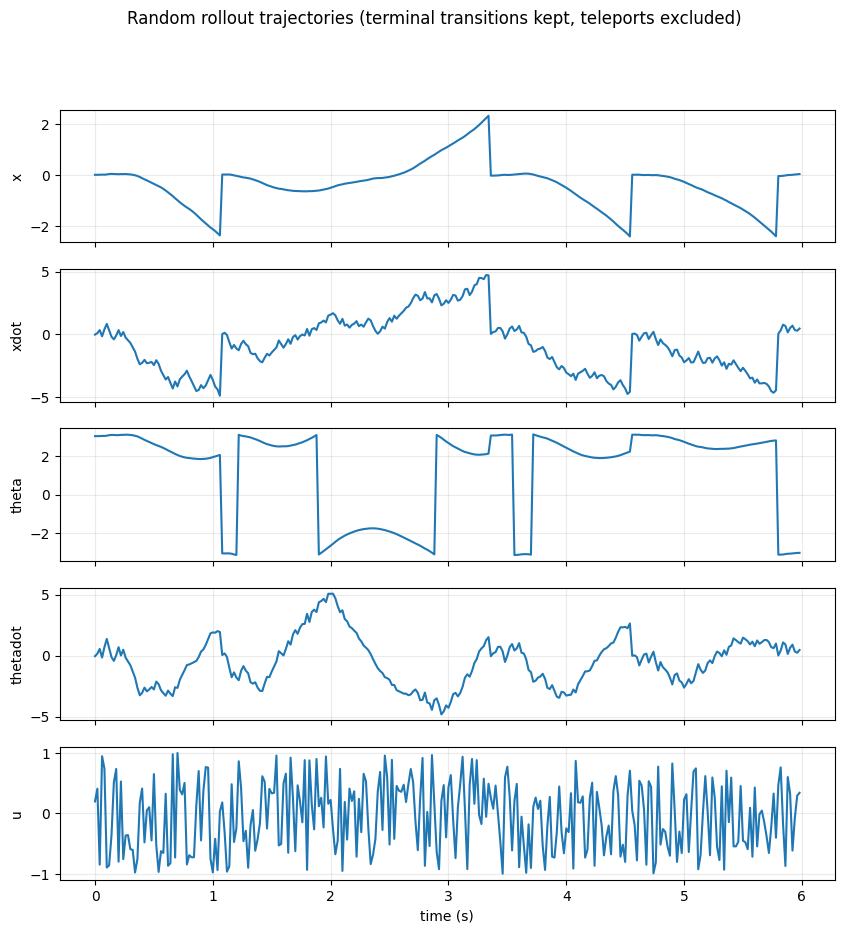

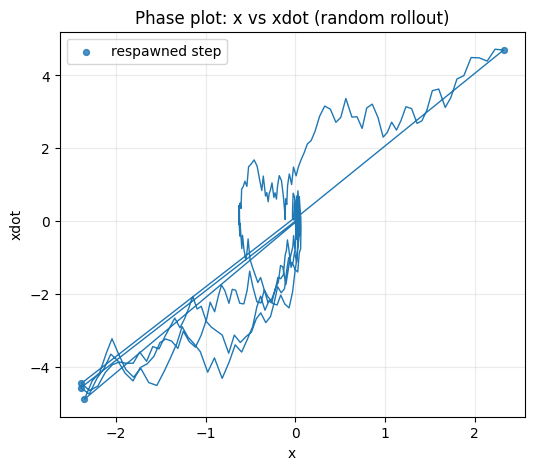

In [ ]:
# ============================
# Cell 2 — Random data collection + PIL render (NO teleport training)
#   ✅ Uses info["terminal_obs"] when respawned=True (keeps real physics transition)
#   ✅ Never trains on reset teleport
#   ✅ Collects dataset in float64 (GP training friendly)
# ============================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display
from PIL import Image, ImageDraw

NP_DTYPE = np.float64  # dataset dtype (GP side)

# ------------------------------------------------------------
# Pure-PIL renderer: (x, theta) -> RGB frame
# ------------------------------------------------------------
def render_cartpole_frame_from_state(
    x, theta,
    x_threshold=2.4,
    W=720, H=450,
    cart_width=70,
    cart_height=35,
    pole_length_px=180,
    wheel_radius=12,
):
    img = Image.new("RGB", (W, H), (255, 255, 255))
    draw = ImageDraw.Draw(img)

    track_y = int(H * 0.70)
    draw.line((int(W * 0.10), track_y, int(W * 0.90), track_y), fill=(40, 40, 40), width=4)

    x = float(x)
    x_clipped = max(-x_threshold, min(x_threshold, x))
    t = (x_clipped + x_threshold) / (2.0 * x_threshold)
    cart_x = int(W * 0.10 + t * (W * 0.80))
    cart_y = track_y - cart_height // 2

    x0 = cart_x - cart_width // 2
    y0 = cart_y - cart_height // 2
    x1 = cart_x + cart_width // 2
    y1 = cart_y + cart_height // 2
    draw.rectangle((x0, y0, x1, y1), fill=(120, 160, 230), outline=(0, 0, 0))

    w1x = cart_x - int(cart_width * 0.25)
    w2x = cart_x + int(cart_width * 0.25)
    wy = track_y
    for wx in [w1x, w2x]:
        draw.ellipse((wx - wheel_radius, wy - wheel_radius, wx + wheel_radius, wy + wheel_radius),
                     fill=(60, 60, 60), outline=(0, 0, 0))

    theta = float(theta)
    pivot_x = cart_x
    pivot_y = y0  # cart top
    tip_x = pivot_x + int(pole_length_px * np.sin(theta))
    tip_y = pivot_y - int(pole_length_px * np.cos(theta))
    draw.line((pivot_x, pivot_y, tip_x, tip_y), fill=(200, 60, 60), width=8)
    draw.ellipse((pivot_x - 6, pivot_y - 6, pivot_x + 6, pivot_y + 6),
                 fill=(0, 0, 0), outline=(0, 0, 0))

    return np.array(img, dtype=np.uint8)

def show_gif(frames_uint8, fps=20):
    fig = plt.figure(figsize=(7.2, 4.5))
    plt.axis("off")
    im = plt.imshow(frames_uint8[0])

    def animate(i):
        im.set_data(frames_uint8[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(frames_uint8), interval=1000 / fps)
    plt.close(fig)
    display(HTML(anim.to_jshtml()))

# ------------------------------------------------------------
# Random collection (keeps REAL terminal transition when respawned)
# ------------------------------------------------------------
def collect_random_dataset_with_render(
    n_steps=1500,
    seed=0,
    resize=(720, 450),
    fps=20,
    edge_respawn=True,
    respawn_penalty=-2.0,
    verbose=False,
):
    env = make_env(
        render_mode=None,
        seed=seed,
        start_down=True,
        edge_respawn=edge_respawn,
        respawn_penalty=respawn_penalty,
    )

    obs, _ = env.reset(seed=seed)
    x, xdot, th, thdot = obs_to_state(obs)

    frames = []
    traj = {
        "x": [], "xdot": [], "theta": [], "thetadot": [],
        "u": [], "reward": [], "respawned": [],
    }

    X_list, ydx_list, ydxdot_list, ydth_list, ydthdot_list = [], [], [], [], []

    for t in range(n_steps):
        u = float(env.action_space.sample()[0])

        # frame from current state BEFORE stepping
        frames.append(render_cartpole_frame_from_state(x, th, W=resize[0], H=resize[1]))

        # step
        obs2, r, terminated, truncated, info = env.step(np.array([u], dtype=np.float32))

        respawned = bool(info.get("respawned", False))

        # use TRUE physics next_obs if respawned
        if respawned and ("terminal_obs" in info):
            obs2_for_training = info["terminal_obs"]
        else:
            obs2_for_training = obs2

        x2, xdot2, th2, thdot2 = obs_to_state(obs2_for_training)

        # logs
        traj["x"].append(x); traj["xdot"].append(xdot); traj["theta"].append(th); traj["thetadot"].append(thdot)
        traj["u"].append(u); traj["reward"].append(float(r)); traj["respawned"].append(respawned)

        # ALWAYS add a valid transition (no teleports)
        X = state_to_features(x, xdot, th, thdot, u, dtype=NP_DTYPE).astype(NP_DTYPE)
        dx = float(x2 - x)
        dxdot = float(xdot2 - xdot)
        dth = float(wrap_pi(th2 - th))
        dthdot = float(thdot2 - thdot)

        X_list.append(X)
        ydx_list.append([dx])
        ydxdot_list.append([dxdot])
        ydth_list.append([dth])
        ydthdot_list.append([dthdot])

        if verbose and (t % 200 == 0):
            print(f"[t={t}] respawned={respawned}  x={x:.2f} th={th:.2f} u={u:+.2f}")

        # advance CONTROL state using returned obs2 (which is reset_obs if respawned)
        x, xdot, th, thdot = obs_to_state(obs2)

    env.close()

    X0 = np.asarray(X_list, dtype=NP_DTYPE)
    Ydx0 = np.asarray(ydx_list, dtype=NP_DTYPE)
    Ydxdot0 = np.asarray(ydxdot_list, dtype=NP_DTYPE)
    Ydth0 = np.asarray(ydth_list, dtype=NP_DTYPE)
    Ydthdot0 = np.asarray(ydthdot_list, dtype=NP_DTYPE)

    return X0, Ydx0, Ydxdot0, Ydth0, Ydthdot0, frames, traj

# ------------------------------------------------------------
# Run data collection + visualize
# ------------------------------------------------------------
N_STEPS_RANDOM = 300
SEED_RANDOM = 0
FPS = 30
RECORD_RGB = True

X0, Ydx0, Ydxdot0, Ydth0, Ydthdot0, frames0, traj0 = collect_random_dataset_with_render(
    n_steps=N_STEPS_RANDOM,
    seed=SEED_RANDOM,
    resize=(720, 450),
    fps=FPS,
    edge_respawn=True,
    respawn_penalty=-2.0,
    verbose=False,
)

print("✅ Random dataset collected (NO teleport training)")
print("X0:", X0.shape)
print("Ydx0:", Ydx0.shape, " Ydxdot0:", Ydxdot0.shape, " Ydth0:", Ydth0.shape, " Ydthdot0:", Ydthdot0.shape)

if RECORD_RGB:
    show_gif(frames0, fps=FPS)

# ------------------------------------------------------------
# Plots
# ------------------------------------------------------------
x_arr = np.array(traj0["x"])
xdot_arr = np.array(traj0["xdot"])
th_arr = np.array(traj0["theta"])
thdot_arr = np.array(traj0["thetadot"])
u_arr = np.array(traj0["u"])
rew_arr = np.array(traj0["reward"])
resp_arr = np.array(traj0["respawned"])
t = np.arange(len(x_arr)) * 0.02

fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)
axs[0].plot(t, x_arr); axs[0].set_ylabel("x")
axs[1].plot(t, xdot_arr); axs[1].set_ylabel("xdot")
axs[2].plot(t, th_arr); axs[2].set_ylabel("theta")
axs[3].plot(t, thdot_arr); axs[3].set_ylabel("thetadot")
axs[4].plot(t, u_arr); axs[4].set_ylabel("u"); axs[4].set_xlabel("time (s)")
for ax in axs: ax.grid(True, alpha=0.25)
fig.suptitle("Random rollout trajectories (terminal transitions kept, teleports excluded)")
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(x_arr, xdot_arr, linewidth=1.0)
plt.scatter(x_arr[resp_arr], xdot_arr[resp_arr], s=18, label="respawned step", alpha=0.8)
plt.xlabel("x"); plt.ylabel("xdot")
plt.title("Phase plot: x vs xdot (random rollout)")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()


In [6]:
# ============================
# Cell 3 — Sparse GP init + training (GPyTorch, GPU)
# Replaces GPflow SVGP.
# Trains 4 independent sparse variational GPs for:
#   Δx, Δxdot, Δθ, Δθdot
# ============================

import numpy as np
import torch
import gpytorch

# ----------------------------
# Dtypes / device
# ----------------------------
TORCH_DTYPE = torch.float64
torch.set_default_dtype(TORCH_DTYPE)   # <- IMPORTANT (must happen before model creation)
device = torch.device("cuda")


def assert_finite(name, arr):
    arr = np.asarray(arr)
    if not np.all(np.isfinite(arr)):
        bad = np.where(~np.isfinite(arr))
        raise ValueError(f"{name} has non-finite values at indices {bad}.")

assert_finite("X0", X0)
assert_finite("Ydx0", Ydx0)
assert_finite("Ydxdot0", Ydxdot0)
assert_finite("Ydth0", Ydth0)
assert_finite("Ydthdot0", Ydthdot0)

# ----------------------------
# Inducing init (same k-center)
# ----------------------------
def kcenter_greedy_indices(X, M, seed=0):
    N = X.shape[0]
    if M >= N:
        return np.arange(N, dtype=np.int64)

    rng = np.random.default_rng(seed)
    first = int(rng.integers(0, N))
    idx = [first]
    d2 = np.sum((X - X[first:first+1])**2, axis=1)

    for _ in range(1, M):
        i = int(np.argmax(d2))
        idx.append(i)
        d2 = np.minimum(d2, np.sum((X - X[i:i+1])**2, axis=1))

    return np.array(idx, dtype=np.int64)

def init_global_inducing_points(X0, M_GLOBAL_MAX=256, method="kcenter", seed=0):
    X0 = np.asarray(X0, dtype=np.float64)
    N0 = X0.shape[0]
    M_GLOBAL = int(min(M_GLOBAL_MAX, N0))

    if N0 <= M_GLOBAL_MAX:
        idx = np.arange(N0, dtype=np.int64)
        Z = X0.copy()
    else:
        if method == "kcenter":
            idx = kcenter_greedy_indices(X0, M_GLOBAL, seed=seed)
        elif method == "random":
            rng = np.random.default_rng(seed)
            idx = rng.choice(N0, size=M_GLOBAL, replace=False).astype(np.int64)
        else:
            raise ValueError(f"Unknown method={method}")
        Z = X0[idx].copy()

    return M_GLOBAL, Z, idx

M_GLOBAL_MAX = 256
M_GLOBAL, Z_GLOBAL, Z_INIT_IDX = init_global_inducing_points(X0, M_GLOBAL_MAX=M_GLOBAL_MAX, method="kcenter", seed=0)
print(f"✅ GLOBAL inducing init: N0={X0.shape[0]}  M_GLOBAL_MAX={M_GLOBAL_MAX}  ->  M_GLOBAL={M_GLOBAL}")

# ----------------------------
# GPyTorch Sparse Variational GP (1D output)
# ----------------------------
class SparseSVGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points: torch.Tensor, input_dim: int, learn_Z: bool):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=learn_Z,
        )
        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=input_dim)
        )

        # Safe-ish init (similar spirit to your GPflow init)
        self.covar_module.outputscale = torch.tensor(1.0, dtype=TORCH_DTYPE, device=device)
        self.covar_module.base_kernel.lengthscale = torch.ones(input_dim, dtype=TORCH_DTYPE, device=device) * 0.5

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def make_model_and_likelihood(Z_global_np, input_dim, likelihood_var=1e-3, learn_Z=False):
    Z = torch.as_tensor(Z_global_np, dtype=TORCH_DTYPE, device=device)
    model = SparseSVGP(Z, input_dim=input_dim, learn_Z=learn_Z).to(device)
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

    # Set + freeze observation noise (matches your "fixed likelihood variance")
    likelihood.noise = torch.tensor(likelihood_var, dtype=TORCH_DTYPE, device=device)
    likelihood.noise_covar.raw_noise.requires_grad_(False)

    return model, likelihood

# ----------------------------
# Training helper (full-batch or mini-batch)
# ----------------------------
def train_svgp(model, likelihood, X_np, Y_np, iters=400, lr=0.01, batch_size=None, seed=0, verbose=True):
    model.train()
    likelihood.train()

    X = torch.as_tensor(np.asarray(X_np), dtype=TORCH_DTYPE, device=device)
    Y = torch.as_tensor(np.asarray(Y_np).reshape(-1), dtype=TORCH_DTYPE, device=device)

    N = X.shape[0]
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=N)

    opt = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=lr)

    rng = np.random.default_rng(seed)

    for k in range(iters):
        opt.zero_grad(set_to_none=True)

        if batch_size is None:
            xb, yb = X, Y
        else:
            idx = rng.choice(N, size=min(batch_size, N), replace=False)
            xb, yb = X[idx], Y[idx]

        with gpytorch.settings.cholesky_jitter(1e-6):
            output = model(xb)
            loss = -mll(output, yb)

        if not torch.isfinite(loss):
            raise FloatingPointError(f"SVGP training diverged at iter {k}: loss={loss.item()}")

        loss.backward()
        opt.step()

        if verbose and (k % 50 == 0 or k == iters - 1):
            print(f"iter {k:04d}  loss {loss.item():.4f}")

    return model, likelihood

# ----------------------------
# Build 4 models
# ----------------------------
D = int(np.asarray(X0).shape[1])

m_dx,     lik_dx     = make_model_and_likelihood(Z_GLOBAL, input_dim=D, likelihood_var=1e-3, learn_Z=False)
m_dxdot,  lik_dxdot  = make_model_and_likelihood(Z_GLOBAL, input_dim=D, likelihood_var=1e-3, learn_Z=False)
m_dth,    lik_dth    = make_model_and_likelihood(Z_GLOBAL, input_dim=D, likelihood_var=1e-3, learn_Z=False)
m_dthdot, lik_dthdot = make_model_and_likelihood(Z_GLOBAL, input_dim=D, likelihood_var=1e-3, learn_Z=False)

INIT_ITERS = 400
INIT_LR = 0.01

train_svgp(m_dx,     lik_dx,     X0, Ydx0,     iters=INIT_ITERS, lr=INIT_LR, batch_size=None, verbose=True)
train_svgp(m_dxdot,  lik_dxdot,  X0, Ydxdot0,  iters=INIT_ITERS, lr=INIT_LR, batch_size=None, verbose=True)
train_svgp(m_dth,    lik_dth,    X0, Ydth0,    iters=INIT_ITERS, lr=INIT_LR, batch_size=None, verbose=True)
train_svgp(m_dthdot, lik_dthdot, X0, Ydthdot0, iters=INIT_ITERS, lr=INIT_LR, batch_size=None, verbose=True)

print("✅ Initial training complete (GPyTorch SVGP)")


✅ GLOBAL inducing init: N0=300  M_GLOBAL_MAX=256  ->  M_GLOBAL=256
iter 0000  loss 498.5944
iter 0050  loss 38.1521
iter 0100  loss 10.8353
iter 0150  loss 3.7260
iter 0200  loss 1.0698
iter 0250  loss -0.1309
iter 0300  loss -0.7595
iter 0350  loss -1.1277
iter 0399  loss -1.3590
iter 0000  loss 549.8661
iter 0050  loss 40.3727
iter 0100  loss 11.5722
iter 0150  loss 4.1211
iter 0200  loss 1.3276
iter 0250  loss 0.0536
iter 0300  loss -0.6194
iter 0350  loss -1.0165
iter 0399  loss -1.2672
iter 0000  loss 498.3350
iter 0050  loss 38.0544
iter 0100  loss 10.8243
iter 0150  loss 3.7289
iter 0200  loss 1.0727
iter 0250  loss -0.1300
iter 0300  loss -0.7595
iter 0350  loss -1.1296
iter 0399  loss -1.3617
iter 0000  loss 587.2294
iter 0050  loss 43.6412
iter 0100  loss 12.7227
iter 0150  loss 4.7283
iter 0200  loss 1.7887
iter 0250  loss 0.4599
iter 0300  loss -0.2500
iter 0350  loss -0.6799
iter 0399  loss -0.9603
✅ Initial training complete (GPyTorch SVGP)


=== Test RMSE (global models) ===
dx        RMSE: 0.000988
dxdot     RMSE: 0.012591
dtheta    RMSE: 0.000518
dthetadot RMSE: 0.030021


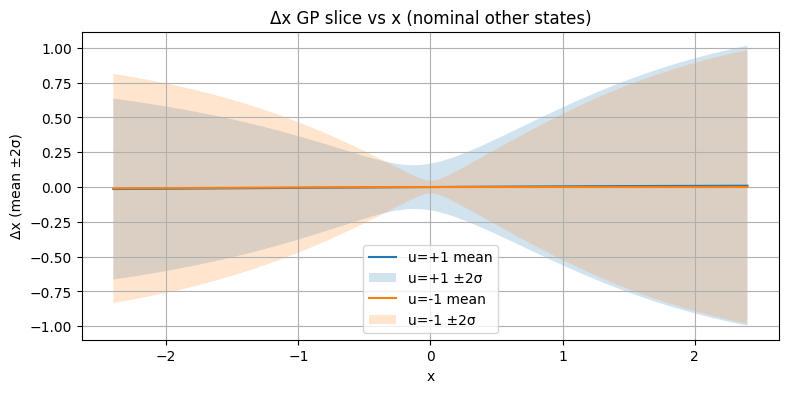

In [7]:
# ============================
# Cell 4 — Evaluate GLOBAL models (GPyTorch)
# Similar plots + RMSE as your GPflow version.
# ============================

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Train/test split (same spirit)
# ------------------------------------------------------------
X0_64      = np.asarray(X0,      dtype=np.float64)
Ydx0_64    = np.asarray(Ydx0,    dtype=np.float64)
Ydxdot0_64 = np.asarray(Ydxdot0, dtype=np.float64)
Ydth0_64   = np.asarray(Ydth0,   dtype=np.float64)
Ydthdot0_64= np.asarray(Ydthdot0,dtype=np.float64)

def _ensure_split_from_X0(test_frac=0.2, seed=0):
    global Xtr, Xte, Ydx_tr, Ydx_te, Ydxdot_tr, Ydxdot_te, Ydth_tr, Ydth_te, Ydthdot_tr, Ydthdot_te
    if "Xtr" in globals() and "Xte" in globals():
        return

    rng = np.random.default_rng(seed)
    N = X0_64.shape[0]
    perm = rng.permutation(N)
    n_te = int(test_frac * N)
    te = perm[:n_te]
    tr = perm[n_te:]

    Xtr = X0_64[tr]
    Xte = X0_64[te]

    Ydx_tr, Ydx_te         = Ydx0_64[tr],     Ydx0_64[te]
    Ydxdot_tr, Ydxdot_te   = Ydxdot0_64[tr],  Ydxdot0_64[te]
    Ydth_tr, Ydth_te       = Ydth0_64[tr],    Ydth0_64[te]
    Ydthdot_tr, Ydthdot_te = Ydthdot0_64[tr], Ydthdot0_64[te]

_ensure_split_from_X0(test_frac=0.2, seed=0)

# ------------------------------------------------------------
# Predict helper (latent f mean/std)
# ------------------------------------------------------------
import torch
import gpytorch

def gp_predict_mu_std(model, X_query_np):
    model.eval()
    Xq = torch.as_tensor(np.asarray(X_query_np, dtype=np.float64), dtype=TORCH_DTYPE, device=device)
    with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.cholesky_jitter(1e-6):
        dist = model(Xq)
        mu = dist.mean.detach().cpu().numpy().reshape(-1)
        var = dist.variance.detach().cpu().numpy().reshape(-1)
        std = np.sqrt(np.maximum(var, 0.0))
    return mu, std

def rmse_np(a, b):
    a = np.asarray(a).reshape(-1)
    b = np.asarray(b).reshape(-1)
    return np.sqrt(np.mean((a - b)**2))

mu_dx, _     = gp_predict_mu_std(m_dx,     Xte)
mu_dxdot, _  = gp_predict_mu_std(m_dxdot,  Xte)
mu_dth, _    = gp_predict_mu_std(m_dth,    Xte)
mu_dthdot, _ = gp_predict_mu_std(m_dthdot, Xte)

print("=== Test RMSE (global models) ===")
print(f"dx        RMSE: {rmse_np(mu_dx,     Ydx_te):.6f}")
print(f"dxdot     RMSE: {rmse_np(mu_dxdot,  Ydxdot_te):.6f}")
print(f"dtheta    RMSE: {rmse_np(mu_dth,    Ydth_te):.6f}")
print(f"dthetadot RMSE: {rmse_np(mu_dthdot, Ydthdot_te):.6f}")

# ------------------------------------------------------------
# Slice plot: sweep x, compare u=+1/-1 at nominal state
# ------------------------------------------------------------
def build_query_sweep_x(u_fixed, n=200, x_min=-2.4, x_max=2.4,
                        xdot=0.0, theta=np.pi, thetadot=0.0):
    xs = np.linspace(x_min, x_max, n)
    Xq = []
    for x in xs:
        feat = state_to_features(x, xdot, theta, thetadot, u_fixed, dtype=np.float64).astype(np.float64)
        Xq.append(feat)
    return xs, np.stack(Xq, axis=0)

xs, Xq_uP = build_query_sweep_x(u_fixed=+1.0)
_,  Xq_uN = build_query_sweep_x(u_fixed=-1.0)

curves = []
for u_fixed, Xq in [(+1.0, Xq_uP), (-1.0, Xq_uN)]:
    mu, std = gp_predict_mu_std(m_dx, Xq)
    curves.append((u_fixed, mu, mu-2*std, mu+2*std))

plt.figure(figsize=(9,4))
for u_fixed, mu, lo, hi in curves:
    plt.plot(xs, mu, label=f"u={u_fixed:+.0f} mean")
    plt.fill_between(xs, lo, hi, alpha=0.2, label=f"u={u_fixed:+.0f} ±2σ")
plt.title("Δx GP slice vs x (nominal other states)")
plt.xlabel("x")
plt.ylabel("Δx (mean ±2σ)")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:

# ============================
# Cell 5 — Streaming update in GPyTorch (OSGPR replacement)
#
# Your TF notebook used GPflow OSGPR to do *streaming* updates without retraining on all past data.
# GPyTorch does not have a drop-in OSGPR class, so we do the standard practical replacement:
#   ✅ Warm-start the existing SVGP (keep variational state)
#   ✅ Do a few ELBO gradient steps on a small NEW batch (or a small replay buffer)
#   ✅ Optional "trust region" regularizer so the variational posterior doesn't jump too far
#
# Two modes:
#   A) Fixed inducing points Z (recommended first, matches your stable TF cell)
#   B) Learn inducing locations (requires models created with learn_Z=True)
# ============================

import numpy as np
import torch
import gpytorch

# Keep everything consistent with the dtype you used in Cell 3
torch.set_default_dtype(TORCH_DTYPE)

def _freeze_module_params(module, freeze: bool = True):
    for p in module.parameters():
        p.requires_grad_(not freeze)

def _get_variational_params(model):
    """Return (variational_mean, chol_variational_covar) as tensors (not detached)."""
    vd = model.variational_strategy._variational_distribution
    m = getattr(vd, "variational_mean", None)
    L = getattr(vd, "chol_variational_covar", None)
    if m is None:
        raise AttributeError("Could not find variational_mean on the variational distribution.")
    if L is None:
        # fallback (older/newer gpytorch naming)
        # If this triggers, paste `dir(vd)` and I'll adjust to your version.
        raise AttributeError("Could not find chol_variational_covar on the variational distribution.")
    return m, L

@torch.no_grad()
def snapshot_variational_state(model):
    m, L = _get_variational_params(model)
    return m.detach().clone(), L.detach().clone()

def stream_update_svgp(
    model,
    likelihood,
    X_new_np,
    Y_new_np,
    iters: int = 50,
    lr: float = 0.01,
    batch_size: int | None = 256,
    freeze_hypers: bool = True,
    freeze_Z: bool = True,
    trust_beta: float = 1e-2,
    jitter: float = 1e-6,
    seed: int = 0,
    verbose: bool = True,
):
    """
    In-place streaming update of an existing SVGP.

    - freeze_hypers=True: only update variational params (and optionally Z if freeze_Z=False and learn_Z=True).
    - trust_beta: L2 trust-region penalty toward the *pre-update* variational params.
    """
    model.train()
    likelihood.train()

    Xnew = torch.as_tensor(np.asarray(X_new_np, dtype=np.float64), dtype=TORCH_DTYPE, device=device)
    Ynew = torch.as_tensor(np.asarray(Y_new_np, dtype=np.float64).reshape(-1), dtype=TORCH_DTYPE, device=device)
    N = int(Xnew.shape[0])

    # Freeze kernel/mean (common for stable online updates)
    if freeze_hypers:
        _freeze_module_params(model.mean_module, freeze=True)
        _freeze_module_params(model.covar_module, freeze=True)

    # Inducing points: only trainable if model was created with learn_Z=True
    if hasattr(model.variational_strategy, "inducing_points"):
        try:
            model.variational_strategy.inducing_points.requires_grad_(not freeze_Z)
        except Exception:
            pass

    # Likelihood noise is frozen in Cell 3; keep it that way here
    for p in likelihood.parameters():
        p.requires_grad_(False)

    # Trust region snapshot
    mean_old, L_old = snapshot_variational_state(model)

    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=N)

    params = [p for p in model.parameters() if p.requires_grad]
    opt = torch.optim.Adam(params, lr=lr)

    rng = np.random.default_rng(seed)

    for k in range(iters):
        opt.zero_grad(set_to_none=True)

        if batch_size is None or batch_size >= N:
            xb, yb = Xnew, Ynew
        else:
            idx = rng.choice(N, size=batch_size, replace=False)
            xb, yb = Xnew[idx], Ynew[idx]

        with gpytorch.settings.cholesky_jitter(jitter):
            out = model(xb)
            loss = -mll(out, yb)

            if trust_beta and trust_beta > 0.0:
                mean_new, L_new = _get_variational_params(model)
                reg = (mean_new - mean_old).pow(2).mean() + (L_new - L_old).pow(2).mean()
                loss = loss + trust_beta * reg

        if not torch.isfinite(loss):
            raise FloatingPointError(f"Streaming update diverged at iter {k}: loss={loss.item()}")

        loss.backward()
        opt.step()

        if verbose and (k % 25 == 0 or k == iters - 1):
            print(f"update iter {k:03d}  loss {loss.item():.4f}")

    return model, likelihood

# ------------------------------------------------------------
# Quick sanity test: collect NEW transitions and do one online update
# ------------------------------------------------------------
# Make a small fresh dataset (different seed than the global training set)
X_new, Ydx_new, Ydxdot_new, Ydth_new, Ydthdot_new, _, _ = collect_random_dataset_with_render(
    n_steps=800,
    seed=123,
    edge_respawn=True,
    respawn_penalty=-2.0,
    verbose=False,
)

print("✅ New data batch:", X_new.shape)

# RMSE before update (on the same test split from Cell 4)
mu_dx_before, _ = gp_predict_mu_std(m_dx, Xte)
rmse_before = rmse_np(mu_dx_before, Ydx_te)
print(f"RMSE(Δx) before update: {rmse_before:.6f}")

# Do a small streaming update (fixed Z, frozen hypers)
stream_update_svgp(
    m_dx,
    lik_dx,
    X_new,
    Ydx_new,
    iters=80,
    lr=0.01,
    batch_size=256,
    freeze_hypers=True,
    freeze_Z=True,
    trust_beta=1e-2,
    jitter=1e-6,
    seed=0,
    verbose=True,
)

mu_dx_after, _ = gp_predict_mu_std(m_dx, Xte)
rmse_after = rmse_np(mu_dx_after, Ydx_te)
print(f"RMSE(Δx) after update:  {rmse_after:.6f}")

print("✅ Step 2 complete: streaming update works (fixed inducing).")


SyntaxError: invalid syntax (2786126114.py, line 131)

In [ ]:

# ============================
# Cell 6 — Torch MPPI using learned GP dynamics (GPU batched)
#   - Uses the 4 trained sparse GPs (Δx, Δxdot, Δθ, Δθdot)
#   - Runs K rollouts of horizon H on GPU
# ============================

import torch
import gpytorch
import numpy as np
import math

# --- MPPI hyperparams (tune if needed) ---
H = 10               # horizon steps (0.8s if tau=0.02)
K = 10             # number of rollouts
MPPI_ITERS = 1       # update iterations per control step
SIGMA = 0.6          # exploration std in action space
LAMBDA = 2.0         # temperature (bigger = smoother)
U_MIN, U_MAX = -1.0, 1.0

# env time step
TAU = getattr(env.unwrapped, "tau", 0.02)

# Feature scaling (must match state_to_features in Cell 1)
X_SCALE = 2.4
V_SCALE = 3.0
W_SCALE = 8.0

def wrap_pi_torch(x: torch.Tensor) -> torch.Tensor:
    return (x + math.pi) % (2 * math.pi) - math.pi

@torch.jit.script
def tanh_div(x: torch.Tensor, s: float):
    return torch.tanh(x / s)

def state_to_features_torch(x: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
    """
    x: (K,4)  [pos, vel, theta, thetadot]
    u: (K,)   action in [-1,1]
    returns: (K,6)
    """
    pos = x[:, 0]
    vel = x[:, 1]
    th  = x[:, 2]
    w   = x[:, 3]
    feats = torch.stack([
        tanh_div(pos, X_SCALE),
        tanh_div(vel, V_SCALE),
        torch.sin(th),
        torch.cos(th),
        tanh_div(w, W_SCALE),
        u,
    ], dim=-1)
    return feats

@torch.no_grad()
def gp_predict_deltas(models, likelihoods, feats: torch.Tensor, with_var: bool = False):
    """
    feats: (N,6) torch tensor on device
    returns:
      mean_deltas: (N,4)
      var_deltas : (N,4) if with_var else None
    """
    # Important: eval mode
    for m in models:
        m.eval()
    for lk in likelihoods:
        lk.eval()

    means = []
    vars_ = []

    with gpytorch.settings.fast_pred_var():
        for m, lk in zip(models, likelihoods):
            dist = lk(m(feats))
            means.append(dist.mean)
            if with_var:
                vars_.append(dist.variance.clamp_min(1e-12))

    mean = torch.stack(means, dim=-1)  # (N,4)
    if with_var:
        var = torch.stack(vars_, dim=-1)
        return mean, var
    return mean, None

def stage_cost(x: torch.Tensor, u: torch.Tensor, var: torch.Tensor | None = None) -> torch.Tensor:
    """
    x: (K,4)
    u: (K,)
    var: (K,4) optional predictive variance
    returns cost: (K,)
    """
    pos = x[:, 0]
    vel = x[:, 1]
    th  = x[:, 2]
    w   = x[:, 3]

    # Match env reward structure (minimize negative reward)
    # reward = cos(theta) - 0.01 x^2 - 0.001 v^2 - 0.001 w^2 - 0.001 u^2
    cost = (
        - torch.cos(th)
        + 0.01 * pos**2
        + 0.001 * vel**2
        + 0.001 * w**2
        + 0.001 * u**2
    )

    # Safety barrier for leaving track
    x_thresh = getattr(env.unwrapped, "x_threshold", 2.4)
    # softplus barrier
    cost = cost + 5.0 * torch.nn.functional.softplus(torch.abs(pos) - x_thresh)

    # Optional risk term (uncertainty-aware / tube-ish)
    if var is not None:
        cost = cost + 0.05 * var.sum(dim=-1)  # tune coefficient

    return cost

def terminal_cost(x: torch.Tensor) -> torch.Tensor:
    pos = x[:, 0]
    th  = x[:, 2]
    # prefer upright (theta ~ 0) and centered
    return 1.0 * (1.0 - torch.cos(th)) + 0.1 * pos**2

def rollout_cost(x0: torch.Tensor, U: torch.Tensor, noise: torch.Tensor, models, likelihoods,
                 use_var: bool = False):
    """
    x0: (4,)
    U: (H,) nominal actions
    noise: (K,H) sampled noise
    returns cost: (K,)
    """
    K_, H_ = noise.shape
    # u samples: (K,H)
    u = (U.unsqueeze(0) + noise).clamp(U_MIN, U_MAX)

    # state: (K,4)
    x = x0.unsqueeze(0).repeat(K_, 1)

    total = torch.zeros(K_, device=x.device, dtype=x.dtype)

    for t in range(H_):
        ut = u[:, t]  # (K,)
        feats = state_to_features_torch(x, ut)
        mu, var = gp_predict_deltas(models, likelihoods, feats, with_var=use_var)
        # apply deltas
        x = x + mu
        x[:, 2] = wrap_pi_torch(x[:, 2])
        total = total + stage_cost(x, ut, var if use_var else None)

    total = total + terminal_cost(x)
    return total, u

def mppi_action(x0_np, U_init=None, use_var=False):
    """
    Computes the first action for the current state using MPPI.
    Returns (u0, U_new)
    """
    x0 = torch.as_tensor(np.asarray(x0_np, dtype=np.float64), device=device, dtype=TORCH_DTYPE)

    if U_init is None:
        U = torch.zeros(H, device=device, dtype=TORCH_DTYPE)
    else:
        U = torch.as_tensor(U_init, device=device, dtype=TORCH_DTYPE).reshape(H)

    # MPPI inner iterations
    for _ in range(MPPI_ITERS):
        noise = SIGMA * torch.randn(K, H, device=device, dtype=TORCH_DTYPE)

        cost, u_roll = rollout_cost(
            x0=x0,
            U=U,
            noise=noise,
            models=[m_dx, m_dxdot, m_dth, m_dthdot],
            likelihoods=[lik_dx, lik_dxdot, lik_dth, lik_dthdot],
            use_var=use_var,
        )

        # weights
        c_min = cost.min()
        w = torch.exp(-(cost - c_min) / LAMBDA)
        w = w / (w.sum() + 1e-12)

        # update U (weighted average of noisy controls)
        U = (w.unsqueeze(-1) * u_roll).sum(dim=0)
        U = U.clamp(U_MIN, U_MAX)

    u0 = float(U[0].detach().cpu().item())

    # shift warm-start
    U_next = torch.cat([U[1:], torch.zeros(1, device=device, dtype=TORCH_DTYPE)], dim=0)
    return u0, U_next.detach()

print("✅ MPPI cell ready.")


✅ MPPI cell ready.


In [19]:

# ============================
# Cell 7 — Closed-loop simulation with MPPI-GP (no online updates yet)
#   - Runs env with MPPI policy using GP model
#   - Records frames (optional)
# ============================

import numpy as np
import matplotlib.pyplot as plt

def run_episode_mppi(seed=0, steps=600, render=False, use_var=False):
    env = make_env(render_mode="rgb_array", seed=seed, start_down=True, edge_respawn=True)
    obs, _ = env.reset(seed=seed)

    frames = []
    U = None
    total_reward = 0.0

    for t in range(steps):
        x, xdot, th, thdot = obs_to_state(obs)

        u, U = mppi_action(np.array([x, xdot, th, thdot], dtype=np.float64), U_init=U, use_var=use_var)
        obs, r, terminated, truncated, info = env.step(np.array([u], dtype=np.float32))
        total_reward += float(r)

        if render and (t % 2 == 0):
            # Use existing PIL renderer if you want; if not available, skip frames
            try:
                st = getattr(env.unwrapped, 'state', None)
                if st is not None:
                    frame = render_cartpole_frame_from_state(st[0], st[2], W=500, H=250)
                frames.append(frame)
            except Exception:
                pass

    env.close()
    return total_reward, frames

reward, frames = run_episode_mppi(seed=0, steps=600, render=True, use_var=False)
print("Total reward:", reward, "frames:", len(frames))

# Preview a few frames if collected
if len(frames) > 0:
    plt.figure()
    plt.imshow(frames[min(len(frames)-1, 10)])
    plt.axis("off")
    plt.show()


Total reward: 251.52701299679282 frames: 0



[online] t=0275  buffer=276  batch=276  iters=40

[online] t=0300  buffer=301  batch=301  iters=40

[online] t=0325  buffer=326  batch=326  iters=40

[online] t=0350  buffer=351  batch=351  iters=40

[online] t=0375  buffer=376  batch=376  iters=40

[online] t=0400  buffer=401  batch=401  iters=40

[online] t=0425  buffer=426  batch=426  iters=40

[online] t=0450  buffer=451  batch=451  iters=40

[online] t=0475  buffer=476  batch=476  iters=40

[online] t=0500  buffer=501  batch=501  iters=40

[online] t=0525  buffer=526  batch=526  iters=40

[online] t=0550  buffer=551  batch=551  iters=40

[online] t=0575  buffer=576  batch=576  iters=40

Total reward (online): 107.15168922643763 frames: 300 buffer: 600


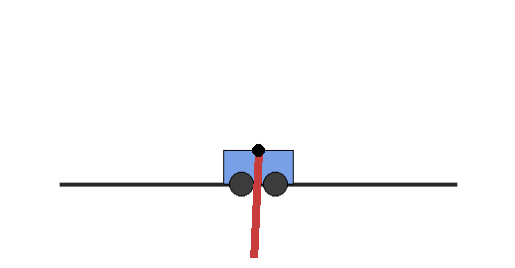

In [11]:
# ============================
# Cell 8 — Closed-loop MPPI + ONLINE GP updates (Step 4)
#
# Goal:
#   Run MPPI in the real environment, collect transitions, and periodically do
#   small streaming SVGP updates (OSGPR replacement) on a replay buffer.
#
# Key detail:
#   If EdgeRespawnWrapper respawns, the *returned* obs is a reset state.
#   For training targets we must use info["terminal_obs"] (TRUE physics next state).
# ============================

import numpy as np
from collections import deque

class ReplayBuffer:
    def __init__(self, maxlen=20000):
        self.X = deque(maxlen=maxlen)   # features (6,)
        self.d = deque(maxlen=maxlen)   # deltas   (4,)
    def __len__(self):
        return len(self.X)
    def add(self, x_feat, delta4):
        self.X.append(np.asarray(x_feat, dtype=np.float64))
        self.d.append(np.asarray(delta4, dtype=np.float64))
    def sample(self, n, seed=0):
        n = int(min(n, len(self.X)))
        rng = np.random.default_rng(seed)
        idx = rng.choice(len(self.X), size=n, replace=False)
        Xb = np.stack([self.X[i] for i in idx], axis=0)
        Db = np.stack([self.d[i] for i in idx], axis=0)  # (n,4)
        return Xb, Db

def compute_delta_from_obs(obs, obs_next_phys):
    # both are (4,) arrays: [x, xdot, theta, thetadot] with theta already wrapped in obs_to_state
    x, xdot, th, thdot = obs_to_state(obs)
    xn, xdotn, thn, thdotn = obs_to_state(obs_next_phys)
    # delta with angle wrap stability
    dth = wrap_pi(thn - th)
    return np.array([xn - x, xdotn - xdot, dth, thdotn - thdot], dtype=np.float64)

def run_episode_mppi_online(
    seed=0,
    steps=600,
    render=False,
    use_var=False,
    # online update knobs
    buffer_maxlen=20000,
    warmup_steps=200,
    update_every=25,
    update_batch=2048,
    online_iters=40,
    online_lr=0.01,
    online_minibatch=256,
    trust_beta=1e-2,
    freeze_hypers=True,
    freeze_Z=True,
    verbose_updates=True,
):
    env = make_env(render_mode=None, seed=seed, start_down=True, edge_respawn=True)
    obs, _ = env.reset(seed=seed)

    frames = []
    U = None
    total_reward = 0.0
    buf = ReplayBuffer(maxlen=buffer_maxlen)

    # For reproducibility of sampling
    sample_seed = 0

    for t in range(steps):
        x, xdot, th, thdot = obs_to_state(obs)

        # 1) MPPI action (uses current GP)
        u, U = mppi_action(np.array([x, xdot, th, thdot], dtype=np.float64), U_init=U, use_var=use_var)

        # 2) step env
        obs_next, r, terminated, truncated, info = env.step(np.array([u], dtype=np.float32))
        total_reward += float(r)

        # 3) For training targets: use TRUE physics next obs at boundary
        if isinstance(info, dict) and info.get("respawned", False):
            obs_next_phys = np.asarray(info["terminal_obs"], dtype=np.float32)
        else:
            obs_next_phys = obs_next

        # 4) Add transition to replay buffer
        feat = state_to_features(x, xdot, th, thdot, u)  # (6,)
        delta4 = compute_delta_from_obs(obs, obs_next_phys)  # (4,)
        buf.add(feat, delta4)

        # 5) Periodic online GP updates (small SVGP steps)
        if (t >= warmup_steps) and (t % update_every == 0) and (len(buf) >= online_minibatch):
            Xb, Db = buf.sample(update_batch, seed=sample_seed)
            sample_seed += 1

            if verbose_updates:
                print(f"\n[online] t={t:04d}  buffer={len(buf)}  batch={Xb.shape[0]}  iters={online_iters}")

            # Update all 4 models (variational params only by default)
            stream_update_svgp(m_dx, lik_dx, Xb, Db[:,0],
                              iters=online_iters, lr=online_lr, batch_size=online_minibatch,
                              freeze_hypers=freeze_hypers, freeze_Z=freeze_Z, trust_beta=trust_beta,
                              jitter=1e-6, seed=0, verbose=False)

            stream_update_svgp(m_dxdot, lik_dxdot, Xb, Db[:,1],
                              iters=online_iters, lr=online_lr, batch_size=online_minibatch,
                              freeze_hypers=freeze_hypers, freeze_Z=freeze_Z, trust_beta=trust_beta,
                              jitter=1e-6, seed=1, verbose=False)

            stream_update_svgp(m_dth, lik_dth, Xb, Db[:,2],
                              iters=online_iters, lr=online_lr, batch_size=online_minibatch,
                              freeze_hypers=freeze_hypers, freeze_Z=freeze_Z, trust_beta=trust_beta,
                              jitter=1e-6, seed=2, verbose=False)

            stream_update_svgp(m_dthdot, lik_dthdot, Xb, Db[:,3],
                              iters=online_iters, lr=online_lr, batch_size=online_minibatch,
                              freeze_hypers=freeze_hypers, freeze_Z=freeze_Z, trust_beta=trust_beta,
                              jitter=1e-6, seed=3, verbose=False)

        # 6) optional frames
        if render and (t % 2 == 0):
            try:
                st = getattr(env.unwrapped, 'state', None)
                if st is not None:
                    frame = render_cartpole_frame_from_state(st[0], st[2], W=500, H=250)
                    frames.append(frame)
            except Exception:
                pass

        # continue control from returned obs (may be reset obs after respawn)
        obs = obs_next

    env.close()
    return total_reward, frames, buf

# --- Run one episode with online updates ---
reward_online, frames_online, buf = run_episode_mppi_online(
    seed=0,
    steps=600,
    render=True,
    use_var=False,
    warmup_steps=200,
    update_every=25,
    update_batch=2048,
    online_iters=40,
    online_lr=0.01,
    online_minibatch=256,
    trust_beta=1e-2,
    freeze_hypers=True,
    freeze_Z=True,
    verbose_updates=True,
)

print("\nTotal reward (online):", reward_online, "frames:", len(frames_online), "buffer:", len(buf))

# Preview a frame if collected
import matplotlib.pyplot as plt
if len(frames_online) > 0:
    plt.figure()
    plt.imshow(frames_online[min(len(frames_online)-1, 10)])
    plt.axis("off")
    plt.show()


Demo total reward: 200.4453408250927
Timesteps: 600 frames: 0
No frames collected. If you want frames, confirm render_cartpole_frame_from_state is available and env has 'state'.


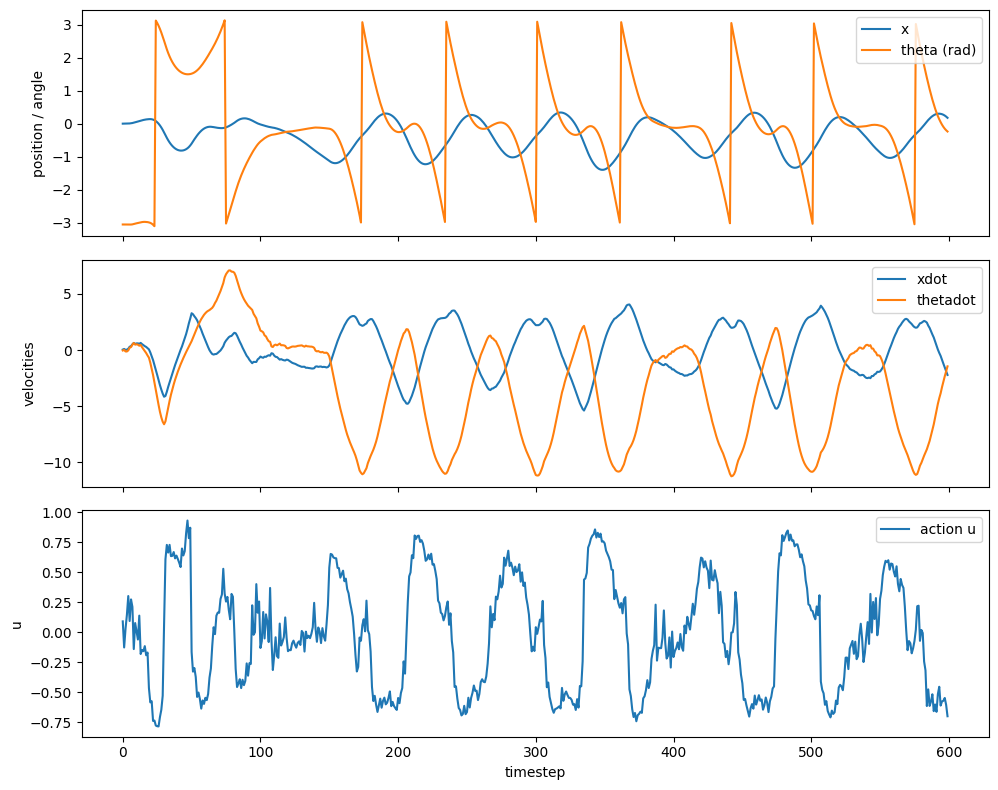

In [12]:

# ============================
# Cell 9 — MPPI demo visualization (GIF + plots)
# ============================

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

def run_episode_mppi_record(seed=1, steps=600, render=True, use_var=False):
    """Run env with MPPI policy (no online updates) and record states/actions + frames."""
    env = make_env(render_mode="rgb_array", seed=seed, start_down=True, edge_respawn=True)
    obs, _ = env.reset(seed=seed)

    frames = []
    U = None
    total_reward = 0.0

    states = []
    actions = []
    rewards = []

    for t in range(steps):
        x, xdot, th, thdot = obs_to_state(obs)

        u, U = mppi_action(np.array([x, xdot, th, thdot], dtype=np.float64), U_init=U, use_var=use_var)

        obs_next, r, terminated, truncated, info = env.step(np.array([u], dtype=np.float32))
        total_reward += float(r)

        states.append([x, xdot, th, thdot])
        actions.append(float(u))
        rewards.append(float(r))

        # Render every 2 steps (keeps GIF smaller)
        if render and (t % 2 == 0):
            try:
                st = getattr(env.unwrapped, 'state', None)
                if st is not None:
                    frame = render_cartpole_frame_from_state(st[0], st[2], W=500, H=250)
                    frames.append(frame)
            except Exception:
                pass

        obs = obs_next

        if terminated or truncated:
            break

    env.close()

    return (
        total_reward,
        np.asarray(states, dtype=np.float64),
        np.asarray(actions, dtype=np.float64),
        np.asarray(rewards, dtype=np.float64),
        frames,
    )

# --- Run a demo episode ---
demo_reward, demo_states, demo_actions, demo_rewards, demo_frames = run_episode_mppi_record(
    seed=1,
    steps=600,
    render=True,
    use_var=False,   # set True if you want a more conservative "risk-aware" rollout
)

print("Demo total reward:", demo_reward)
print("Timesteps:", len(demo_states), "frames:", len(demo_frames))

# --- Save + show GIF ---
if len(demo_frames) > 0:
    try:
        import imageio.v2 as imageio
    except Exception:
        import imageio

    gif_path = "cartpole_mppi_demo.gif"
    # duration is seconds per frame; with frame every 2 steps, 30 fps looks OK visually
    imageio.mimsave(gif_path, demo_frames, duration=1/30)
    display(Image(filename=gif_path))
    print("Saved GIF:", gif_path)
else:
    print("No frames collected. If you want frames, confirm render_cartpole_frame_from_state is available and env has 'state'.")

# --- Plots: state + action ---
if len(demo_states) > 0:
    t = np.arange(len(demo_states))

    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    axs[0].plot(t, demo_states[:,0], label="x")
    axs[0].plot(t, demo_states[:,2], label="theta (rad)")
    axs[0].set_ylabel("position / angle")
    axs[0].legend()

    axs[1].plot(t, demo_states[:,1], label="xdot")
    axs[1].plot(t, demo_states[:,3], label="thetadot")
    axs[1].set_ylabel("velocities")
    axs[1].legend()

    axs[2].plot(t, demo_actions, label="action u")
    axs[2].set_xlabel("timestep")
    axs[2].set_ylabel("u")
    axs[2].legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# ============================
# Cell 9 — FAST MPPI demo visualization (run fast, render after)
# - No rendering inside the control loop
# - GIF is generated afterward from recorded states
# ============================

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image as DisplayImage, display

def run_episode_mppi_record_fast(seed=1, steps=600, use_var=False):
    """Run env with MPPI policy (no online updates), record states/actions, NO rendering inside loop."""
    # IMPORTANT: do NOT request rgb_array if you won't call env.render()
    env = make_env(render_mode=None, seed=seed, start_down=True, edge_respawn=True)
    obs, _ = env.reset(seed=seed)

    U = None
    total_reward = 0.0

    states = []
    actions = []
    rewards = []

    for t in range(steps):
        x, xdot, th, thdot = obs_to_state(obs)

        # MPPI
        u, U = mppi_action(np.array([x, xdot, th, thdot], dtype=np.float64),
                           U_init=U, use_var=use_var)

        obs_next, r, terminated, truncated, info = env.step(np.array([u], dtype=np.float32))
        total_reward += float(r)

        # log AFTER applying action (so visuals match what happened)
        x2, xdot2, th2, thdot2 = obs_to_state(obs_next)
        states.append([x2, xdot2, th2, thdot2])
        actions.append(float(u))
        rewards.append(float(r))

        obs = obs_next
        if terminated or truncated:
            break

    env.close()

    return (
        total_reward,
        np.asarray(states, dtype=np.float64),
        np.asarray(actions, dtype=np.float64),
        np.asarray(rewards, dtype=np.float64),
    )

def render_gif_from_states(states, stride=4, W=500, H=250, fps=30, gif_path="cartpole_mppi_demo.gif"):
    """Render frames AFTER the run using render_cartpole_frame_from_state(x, theta)."""
    xs = states[::stride, 0]
    ths = states[::stride, 2]

    # Render frames
    frames = []
    for x, th in zip(xs, ths):
        frame = render_cartpole_frame_from_state(float(x), float(th), W=W, H=H)
        # ensure uint8 numpy array
        if isinstance(frame, np.ndarray) and frame.dtype != np.uint8:
            frame = np.clip(frame, 0, 255).astype(np.uint8)
        frames.append(frame)

    # Write GIF (streaming writer is usually faster + less RAM than mimsave)
    import imageio.v2 as imageio
    with imageio.get_writer(gif_path, mode="I", fps=fps) as writer:
        for fr in frames:
            writer.append_data(fr)

    return gif_path, len(frames)

# --- Run fast episode (no rendering overhead) ---
demo_reward, demo_states, demo_actions, demo_rewards = run_episode_mppi_record_fast(
    seed=1,
    steps=600,
    use_var=False,  # keep False for max speed
)

print("Demo total reward:", demo_reward)
print("Timesteps:", len(demo_states))

# --- Render GIF AFTER (tunable for speed/quality) ---
gif_path, nframes = render_gif_from_states(
    demo_states,
    stride=6,     # ↑ bigger stride = fewer frames = faster
    W=420, H=210, # smaller = faster
    fps=30,
    gif_path="cartpole_mppi_demo.gif",
)
print("GIF frames:", nframes)
DisplayImage(Image(filename=gif_path))
print("Saved GIF:", gif_path)

# --- Plots: state + action ---
if len(demo_states) > 0:
    t = np.arange(len(demo_states))

    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    axs[0].plot(t, demo_states[:,0], label="x")
    axs[0].plot(t, demo_states[:,2], label="theta (rad)")
    axs[0].set_ylabel("position / angle")
    axs[0].legend()

    axs[1].plot(t, demo_states[:,1], label="xdot")
    axs[1].plot(t, demo_states[:,3], label="thetadot")
    axs[1].set_ylabel("velocities")
    axs[1].legend()

    axs[2].plot(t, demo_actions, label="action u")
    axs[2].set_xlabel("timestep")
    axs[2].set_ylabel("u")
    axs[2].legend()

    plt.tight_layout()
    plt.show()
